# Cumulative app version of fig 3

Cumulative yield

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [32]:
import pandas as pd

import seaborn as sns

from math import log, floor

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels,
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import trait_vec, gamma_dist, get_dist_mean
# from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote
from poly2.consts import FUNG_DECAY_RATE, MUTATION_PROP, MUTATION_SCALE

In [3]:
df = pd.read_csv('../outputs/combined/processed_scan_cumulative.csv')

df.head()

,run,year,dose,yld,cum_yld,mu,b,asymptote,dec_rate_multiplier,m_prop_multiplier,m_scale_multiplier,ME_mean
0,0.0,1.0,1.0,10.021293,10.021293,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
1,0.0,2.0,1.0,10.021275,20.042568,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
2,0.0,3.0,1.0,10.021238,30.063805,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
3,0.0,4.0,1.0,10.021156,40.084961,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
4,0.0,5.0,1.0,10.020970,50.105931,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


In [4]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize

## Default pars

In [34]:
# cf = Config(verbose=False, n_k=300)

# default_b = cf.k_b
# default_mu = cf.k_mu
# a = cf.k_mu * cf.k_b
# init_dist = gamma_dist(cf.n_k, a, cf.k_b)
# tv = trait_vec(cf.n_k)
# # NB get_dist_var/mean needs init_dist to be shape (n_k, n_years)
# reshaped = init_dist.reshape((cf.n_k, 1))
# default_ME_mean = get_dist_mean(reshaped, tv)[0]

In [ ]:
cf = Config(verbose=False, n_k=300)

default_b = cf.k_b
default_mu = cf.k_mu
a = cf.k_mu * cf.k_b

default_ME_mean = (default_b/(default_b+1))**a

## Bar df

In [29]:
barchartdf = (
    df
    .loc[:, ['dose', 'year']]
    .groupby('year')
    .value_counts()
    .reset_index()
    .rename(columns={0: 'count'})
    .pivot(index='year', columns='dose', values='count')
    
)

barchartdf.head(10)

dose,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
year,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,9999.0
4.0,NaN,1.0,3.0,7.0,10.0,10.0,13.0,14.0,5.0,9937.0
5.0,NaN,8.0,23.0,36.0,22.0,17.0,20.0,13.0,18.0,9843.0
6.0,1.0,32.0,65.0,41.0,29.0,30.0,28.0,22.0,29.0,9723.0
7.0,6.0,71.0,75.0,44.0,52.0,43.0,34.0,36.0,27.0,9612.0
8.0,13.0,108.0,77.0,65.0,66.0,52.0,38.0,30.0,40.0,9511.0
9.0,29.0,124.0,82.0,95.0,68.0,46.0,53.0,40.0,43.0,9420.0


<AxesSubplot:xlabel='year'>

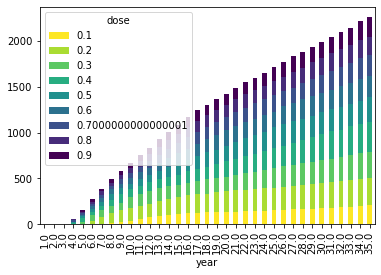

In [14]:
(
    barchartdf
    .iloc[:, :9]
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
        legend=True
    )
)

## Line df

In [41]:
pars = (
    df
    .loc[lambda x: x.run==5]
    .head(1)
    .filter(regex='^((?!in_0).)*$')
    .filter(regex='^((?!yld).)*$')
    .drop(['dose', 'year', 'run'], axis=1)
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

pars

,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
175,19.355842,1.322778,0.45615,1.849157,0.109038,1.718981,0.54461


In [58]:
pars.round(4)

,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
175,19.3558,1.3228,0.4562,1.8492,0.109,1.719,0.5446


In [59]:
49*35

1715

In [42]:
n_years = 35

cf = Config(
    n_years=n_years,
    n_k=300,
    verbose=False
)

cf.k_mu = pars.mu.values[0]
cf.k_b = pars.b.values[0]
cf.asymptote = pars.asymp.values[0]
cf.decay_rate = FUNG_DECAY_RATE * pars.dec_rate.values[0]
cf.mutation_proportion = MUTATION_PROP * pars.m_prop.values[0]
cf.mutation_scale_fung = MUTATION_SCALE * pars.m_scale.values[0]

In [43]:
%%time

line_df = pd.DataFrame()

for dose in tqdm(np.linspace(0.1, 1, 10)):

    cf.doses = dose*np.ones(cf.n_years)

    sim = SimulatorOneTrait(cf)

    data = sim.run_model()
    
    tmp = pd.DataFrame(
        dict(
            dose=np.repeat(dose, n_years),
            yld=data['yield_vec'],
            year=np.arange(1, 1+n_years),
        )
    )
    
    line_df = pd.concat([line_df, tmp])
    
line_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:23<00:00, 38.35s/it]

Wall time: 6min 23s


,dose,yld,year
0,0.1,9.085359,1
1,0.1,9.085358,2
2,0.1,9.085357,3
3,0.1,9.085356,4
4,0.1,9.085354,5
...,...,...,...
30,1.0,9.060134,31
31,1.0,9.052027,32
32,1.0,9.044150,33
33,1.0,9.036489,34


In [44]:
ldf = (
    line_df
    .reset_index(drop=True)
    .groupby('dose')
    .apply(lambda df: 
           df.assign(cumyld = lambda x: np.cumsum(x.yld))
    )
    .assign(avyld = lambda df: df.cumyld / df.year)
)

ldf.head()

,dose,yld,year,cumyld,avyld
0,0.1,9.085359,1,9.085359,9.085359
1,0.1,9.085358,2,18.170717,9.085358
2,0.1,9.085357,3,27.256074,9.085358
3,0.1,9.085356,4,36.341429,9.085357
4,0.1,9.085354,5,45.426784,9.085357


In [51]:
best_dose = (
    ldf
    .groupby('year')
    .apply(lambda x: x.loc[x.cumyld.idxmax()])
    .assign(yy=9.9)
    .reset_index(drop=True)
    .loc[:, ['dose', 'year', 'yy']]
)

best_dose.head()

,dose,year,yy
0,1.0,1.0,9.9
1,1.0,2.0,9.9
2,1.0,3.0,9.9
3,1.0,4.0,9.9
4,1.0,5.0,9.9


In [52]:
eps = 0.2

bd_use = (
    pd.concat([
        best_dose.assign(year=lambda x: x.year - eps),
        best_dose.assign(year=lambda x: x.year + eps),
    ])
    .drop_duplicates()
    .sort_values('year')
)

## The plot

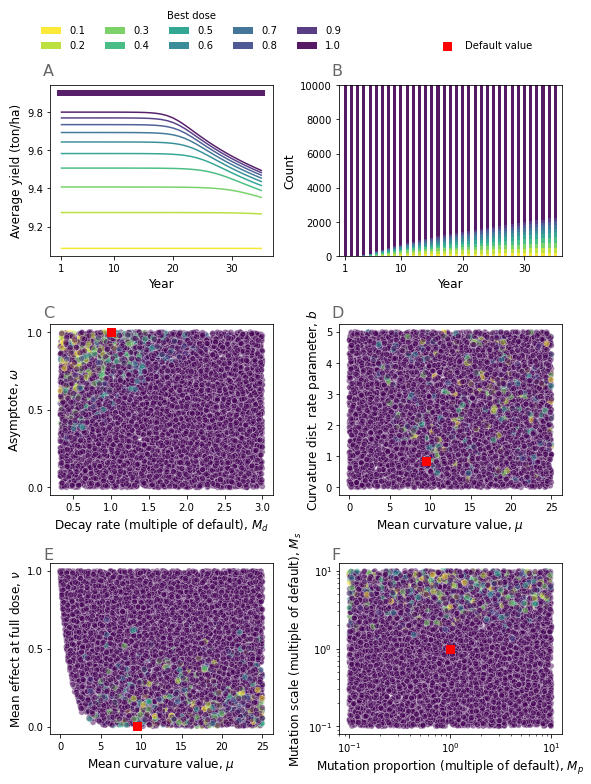

In [56]:
f, ax = plt.subplots(3, 2, figsize=(8, 12))

# A
alpha_A = 0.9

COLZ = sns.color_palette('viridis_r', n_colors=60)

for ind, dose in enumerate(line_df.dose.unique()):
    n_d = len(line_df.dose.unique())
    
    col_ind = floor(ind*59/(-1+n_d))
    
    colr = COLZ[col_ind]
    
    ax[0][0].plot(
            ldf.loc[lambda x: x.dose==dose].year,
            ldf.loc[lambda x: x.dose==dose].avyld,
            alpha=alpha_A,
            c=colr)
    
    ax[0][0].plot(bd_use.loc[lambda x: x.dose==dose].year,
            bd_use.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha_A,
            lw=6)

# B
(
    barchartdf
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
        alpha = 0.9,
        ax=ax[0][1],
        legend=True,
    )
)


# TYPE 2

dfu = (
    df
    .loc[lambda x: x.year.isin([10])]
    .rename(columns={'dose': 'best_dose'})
)

alpha = 0.5

# C
sns.scatterplot(
    x='dec_rate_multiplier',
    y='asymptote',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][0],
    legend=False,
)

# D
sns.scatterplot(
    x='mu',
    y='b',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][1],
    legend=False,
)

# E
sns.scatterplot(
    x='mu',
    y='ME_mean',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[2][0],
    legend=False,
)

# F
sns.scatterplot(
    x='m_prop_multiplier',
    y='m_scale_multiplier',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[2][1],
    legend=False,
)

cc = 'red'
marker = 's'
ss = 80






# layout


# A
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('Average yield (ton/ha)')
ax[0][0].set_xticks([1,10,20,30])
ax[0][0].set_xticklabels([1,10,20,30], rotation=0)


# B
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('Count')

ax[0][1].set_ylim([0,10000])
ax[0][1].set_xlim([-1, 35])
ax[0][1].set_xticks([0, 9, 19, 29])
ax[0][1].set_xticklabels([1,10,20,30], rotation=0)

# C
ax[1][0].set_xlabel(r'Decay rate (multiple of default), $M_d$')
ax[1][0].set_ylabel(r'Asymptote, $\omega$')

ax[1][0].set_yticks([0, 0.5, 1])
ax[1][0].scatter([1], [1], c=cc, s=ss, marker=marker, label='Default value')


# D
ax[1][1].set_xlabel(r'Mean curvature value, $\mu$')
ax[1][1].set_ylabel(r'Curvature dist. rate parameter, $b$')

ax[1][1].scatter([default_mu], [default_b], c=cc, s=ss, marker=marker)



# E
ax[2][0].set_xlabel(r'Mean curvature value, $\mu$')
ax[2][0].set_ylabel(r'Mean effect at full dose, $\nu$')

ax[2][0].scatter([default_mu], [default_ME_mean], c=cc, s=ss, marker=marker)
ax[2][0].set_yticks([0, 0.5, 1])


# F
ax[2][1].set_xlabel(r'Mutation proportion (multiple of default), $M_p$')
ax[2][1].set_ylabel(r'Mutation scale (multiple of default), $M_s$')

ax[2][1].set_xscale('log')
ax[2][1].set_yscale('log')
ax[2][1].scatter([1], [1], c=cc, s=ss, marker=marker)



plt.tight_layout(rect=[0,0,1,0.83], h_pad=3)

ax[0][1].legend(
    bbox_to_anchor=(0.05, 1.15),
    loc='lower right',
    labels=[f'{ii:.1f}' for ii in np.arange(0.1,1.1,0.1)],
    title='Best dose',
    ncol=5,
    framealpha=0,
)

ax[1][0].legend(
    bbox_to_anchor=(1.7, 2.55),
    loc='lower left',
    framealpha=0,
)

get_corner_annotations(2, 3, 0.075, 0.82, 0.5, 0.28, plt)

In [57]:
f.savefig('../figures/paper/app3_c_fig2.jpg', dpi=300, bbox_inches="tight")